# DATA_608_Module_4
Md. Jalal Uddin

In [8]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

import plotly.plotly as py
import plotly.graph_objs as go

from pyproj import Proj, transform

import matplotlib.pyplot as plt

import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
from functools import partial

In [9]:
url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json'
trees = pd.read_json(url)
trees.head(10)

,address,bbl,bin,block_id,boro_ct,borocode,boroname,brch_light,brch_other,brch_shoe,...,tree_dbh,tree_id,trnk_light,trnk_other,trunk_wire,user_type,x_sp,y_sp,zip_city,zipcode
0,108-005 70 AVENUE,4.022210e+09,4052307.0,348711,4073900,4,Queens,No,No,No,...,3,180683,No,No,No,TreesCount Staff,1.027431e+06,202756.7687,Forest Hills,11375
1,147-074 7 AVENUE,4.044750e+09,4101931.0,315986,4097300,4,Queens,No,No,No,...,21,200540,No,No,No,TreesCount Staff,1.034456e+06,228644.8374,Whitestone,11357
2,390 MORGAN AVENUE,3.028870e+09,3338310.0,218365,3044900,3,Brooklyn,No,No,No,...,3,204026,No,No,No,Volunteer,1.001823e+06,200716.8913,Brooklyn,11211
3,1027 GRAND STREET,3.029250e+09,3338342.0,217969,3044900,3,Brooklyn,No,No,No,...,10,204337,No,No,No,Volunteer,1.002420e+06,199244.2531,Brooklyn,11211
4,603 6 STREET,3.010850e+09,3025654.0,223043,3016500,3,Brooklyn,No,No,No,...,21,189565,No,No,No,Volunteer,9.909138e+05,182202.4260,Brooklyn,11215
5,8 COLUMBUS AVENUE,1.011310e+09,1076229.0,106099,1014500,1,Manhattan,No,No,No,...,11,190422,No,No,No,Volunteer,9.884187e+05,219825.5227,New York,10023
6,120 WEST 60 STREET,1.011310e+09,1076229.0,106099,1014500,1,Manhattan,No,No,No,...,11,190426,No,No,No,Volunteer,9.883112e+05,219885.2785,New York,10023
7,311 WEST 50 STREET,1.010410e+09,1086093.0,103940,1012700,1,Manhattan,No,No,No,...,9,208649,No,No,No,Volunteer,9.877691e+05,217157.8561,New York,10019
8,65 JEROME AVENUE,NaN,NaN,407443,5006400,5,Staten Island,No,No,No,...,6,209610,No,No,No,TreesCount Staff,9.630732e+05,156635.5542,Staten Island,10305
9,638 AVENUE Z,3.072350e+09,3320727.0,207508,3037402,3,Brooklyn,No,No,No,...,21,192755,No,No,No,TreesCount Staff,9.926537e+05,152903.6306,Brooklyn,11223


In [10]:
print(trees.shape)
cat_type = CategoricalDtype(categories=["Poor", "Fair", "Good"], ordered = True)
trees['health'] = trees['health'].astype(cat_type)
print(trees['health'].describe())
print(trees['health'].cat.codes[:10])
trees['health'].isna().sum()
trees['health'] = trees['health'].fillna('Fair')
trees['health'] = trees['health'].cat.codes
print(trees['health'][:10])
print(trees['health'].describe())

(1000, 45)
count      973
unique       3
top       Good
freq       736
Name: health, dtype: object
0    1
1    1
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    1
dtype: int8
0    1
1    1
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    1
Name: health, dtype: int8
count    1000.000000
mean        1.682000
std         0.570264
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: health, dtype: float64


In [11]:
trees['steward'] = trees['steward'].fillna('None')

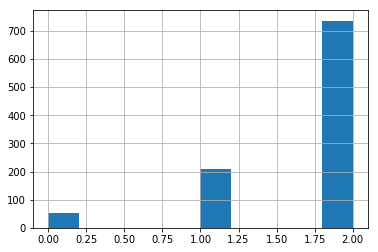

In [12]:
trees['health'].hist()
plt.show()

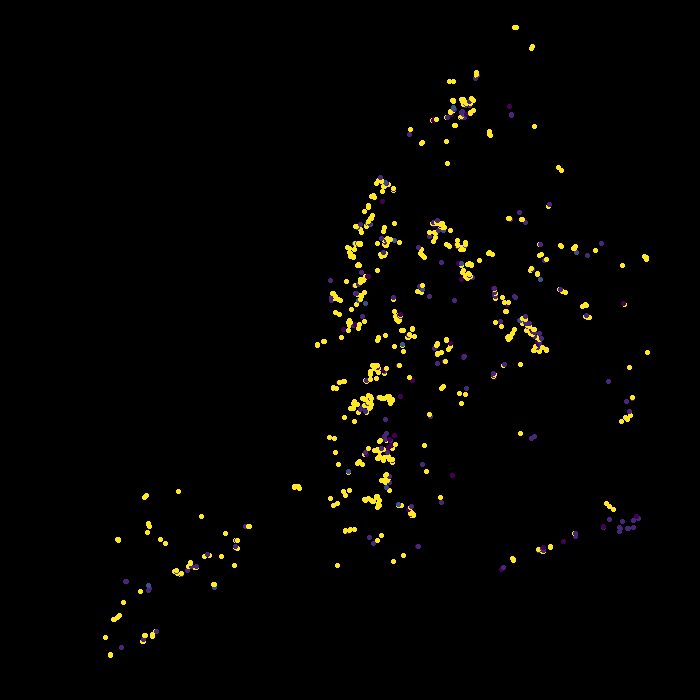

In [13]:
#Using some code to transform the x and y into long and lat and to get map locating trees.
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
trees['x_sp'] = 0.3048*trees['x_sp']
trees['y_sp'] = 0.3048*trees['y_sp']
trees['lon'], trees['lat'] = transform(nyli, wgs84, trees['x_sp'].values, trees['y_sp'].values)

trees = trees[(trees['lon'] < -60) & (trees['lon'] > -100) & (trees['lat'] < 60) & (trees['lat'] > 20)]

background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(trees, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(viridis), how='log')
export(tf.spread(view, px=2), 'trees')
agg = cvs.points(trees, 'lon', 'lat', ds.mean('health'))
view = tf.shade(agg, cmap = cm(viridis), how='eq_hist')
export(tf.spread(view, px=2), 'trees_health')

In [14]:
app = dash.Dash()

app.layout = html.Div(children=[
    html.H1(children = 'NYC Street Tree Health'),
    html.P('These graphics display the overall health of trees along city streets in NYC'),
    html.P('First select a Borough: '),
    dcc.RadioItems(
        id='dropdown-a',
        options=[{'label': i, 'value': i} for i in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']],
        value='Queens'
    ),
    html.Div(id='output-a'),
    html.P("0 = Poor Health; 1 = Fair Health, 2 = Good Health"),
    dcc.RadioItems(
        id='dropdown-b',
        options=[{'label': i, 'value': i} for i in trees['steward'].unique()],
        value='None'
    ),
    html.Div(id='output-b'),
    html.P("0 = Poor Health; 1 = Fair Health, 2 = Good Health")
    ])

@app.callback(
        Output(component_id='output-a', component_property='children'),
        [Input(component_id='dropdown-a', component_property='value')]
        )

def boro_graph(input_data):
    df = trees[trees.boroname == input_data]
    
    return dcc.Graph(
            id='Health by Borough',
            figure={
                    'data':[
              {'x':df['health'], 'type': 'histogram','name': 'Health by Borough'}
          ],
          'layout':{
              'title':"Health by Borough"
                  }
          }
              )

@app.callback(
        Output(component_id='output-b', component_property='children'),
        [Input(component_id='dropdown-b', component_property='value')]
        )

def steward_graph(input_data):
    df = trees[trees.steward == input_data]
    
    return dcc.Graph(
            id='Health by Steward',
            figure={
                    'data':[
              {'x':df['health'], 'type': 'histogram','name': 'Health by Stewardship'}
          ],
          'layout':{
              'title':"Health by Stewardship"
                  }
          }
              )


if __name__ == '__main__':
    app.run_server(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
